Initialize

In [65]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"   # Must be called before importing keras
import keras
import torch
import tensorflow as tf
from scipy import stats
from imblearn.over_sampling import RandomOverSampler
import warnings

warnings.filterwarnings("ignore")
seed = 123

# # Create requirements file
# pip list -format-freeze > requirements.txt

In [66]:
# # Testing GPU access
# ## Using pytorch because jax won't work with cuda on Windows 11, and the tensorflow installation didn't recognize the gpu
# ## However, pytorch is MUCH slower when all use the GPU.
# print("Is CUDA available:", torch.cuda.is_available())
# print("Current device:", torch.cuda.get_device_name(0))

Import data and concatenate

In [67]:
outs = pl.read_excel("Data/Outcomes/outcomes.xlsx")
preds = pl.read_csv("Data/Predictors/Sleep(1).csv")
for i in range(9):
    temp = pl.read_csv(f"Data/Predictors/Sleep({i + 2}).csv")
    preds = pl.concat([preds, temp], how = "vertical")
preds = preds.rename({"Sleep Score 4 Weeks": "Date", "Score": "Sleep Score"})

# Retain only useful columns
preds = preds.select(pl.nth(0,1,2,3,5, 6, 7))

# Convert date column to date format
preds = preds.with_columns(
    (pl.col("Date") + " 2024")
    .str.strptime(pl.Date, format="%b %e %Y")
    .alias("Date"))

Merge factors and outcome on date

In [68]:
# Note: the predictors are mnissing data for 9/24/24 due to crossing the dateline.
df = preds.join(outs, how = "inner", on = "Date")

Convert temperature changes to numeric

In [69]:
df = df.with_columns(
    pl.col("Skin Temp Change").str.strip_chars_end("°").cast(pl.Float64))

EDA

<Axes: >

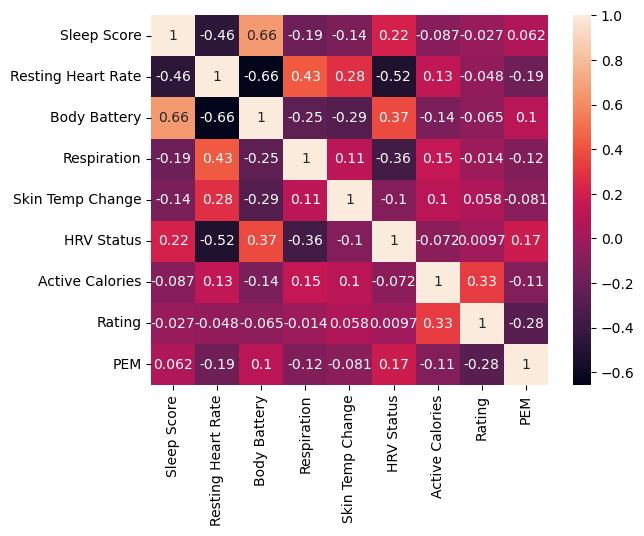

In [70]:
# Plot correlation matrix
sns.heatmap(df.to_pandas().iloc[:, 1:10].corr(), annot=True)

## Despite some collinearity, no variables appear duplicative.
## The low correlations between the outcomes and any other variable, including other outcomes,
    ## portend ill for the analysis' success.

Prep outcome column for ordinal classification

In [71]:
# Number of possible ratings
classes = 5

# Converting range of ratings to 0-based
df = df.with_columns((pl.col('Rating') - 1).alias('Rating'))

# Converting ratings to variation on one-hot encoding
y_matrix = np.zeros((len(df['Rating']), classes - 1))
for i in range(len(df['Rating'])):
    for j in range(classes - 1):
        y_matrix[i, j] = 1 if df['Rating'][i] > j else 0

# Adding new outcome columns to df (indexed as 10-13)
df = pl.concat([df, pl.from_numpy(y_matrix)], how = "horizontal")

Standardize and split data

In [72]:
scaler = StandardScaler()
dfp = df.to_pandas()
dfp.iloc[:, 1:7] = scaler.fit_transform(dfp.iloc[:, 1:7])

# Initial split between train, validation, and test sets
## Prioritizing training due to small dataset
dfp_train, dfp_test = train_test_split(dfp.iloc[:, 1:], test_size=0.3, random_state=seed)
dfp_test, dfp_val = train_test_split(dfp_test, test_size=0.5, random_state=seed)
# X_val = dfp_val.iloc[:, 0:6]
# y_val = dfp_val.iloc[:, 9:]
X_test = dfp_test.iloc[:, 0:6]
y_test = dfp_test.iloc[:, 9:]

y_test_orig = dfp_test.iloc[:, 7]  # Used in calculating metrics on test set

Balance training and validation data. Validation is balanced due to problems fitting models to low-frequency categories. A custom metric might be more appropriate, but my first attempt didn't work.

In [73]:
# Split dfp into ratings and rest. Then split rest into predictors and outcome matrix
ros = RandomOverSampler(random_state=seed)
X_train, y_train_ratings = ros.fit_resample(dfp_train.drop(dfp_train.columns[6], axis=1), dfp_train.iloc[:, 7])
y_train = X_train.iloc[:, -4:]
X_train = X_train.iloc[:, 0:6]

X_val, y_val_ratings = ros.fit_resample(dfp_val.drop(dfp_val.columns[6], axis=1), dfp_val.iloc[:, 7])
y_val = X_val.iloc[:, -4:]
X_val = X_val.iloc[:, 0:6]

Create ordinal classification model


In [74]:
## Each hyperparameter, including the loss, the metric, the number of layers and nodes, whether to use L2 regularization on each layer, 
## the batch size, the dropout rate, the learning rate, and the L2 penalty was determined through a manual grid search.

## The downside of the matrix approach is that a custom loss is not possible (for me and Claude, at least).

keras.utils.set_random_seed(seed)
input_shape = (6,)

# Set hyperparamters
batch = 32  
nodes = 26  
drop_rate = 0.5  
learn = 0.002  
pen = 0.01 

model = keras.Sequential(
    [ keras.layers.Input(shape = input_shape),
        keras.layers.Dense(nodes, activation="relu", 
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "layer1"),
        keras.layers.Dropout(drop_rate, name = "dropout1"),
        keras.layers.Dense(nodes, activation="relu", 
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "layer2"),
        keras.layers.Dropout(drop_rate, name = "dropout2"),
        keras.layers.Dense(nodes, activation="relu",  
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "layer3"),
        keras.layers.Dense(classes - 1, activation='sigmoid',
                        #    kernel_regularizer=keras.regularizers.L2(l2=pen), 
                           kernel_initializer = keras.initializers.HeNormal(), 
                           name = "output")]
                           )
# model.summary()  # Uncomment to print architecture on screen

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learn),
    # metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

callbacks = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=100, 
                                           restore_best_weights=True)]

results = model.fit(
    X_train, 
    y_train, 
    validation_data = (X_val, y_val), 
    epochs = 1000, 
    verbose = 0,
    callbacks=callbacks,
    batch_size = batch
    )

print(f'Best validation accuracy: {round(max(results.history['val_accuracy']), 3)}')

test_metrics = model.evaluate(X_test, y_test, return_dict = True, verbose = 0)
print(f'Test accuracy: {round(test_metrics['accuracy'], 3)}')

model.save("final_model_rating_classification.keras")  # save final model
model_final = keras.saving.load_model("final_model_rating_classification.keras")  # reload
predictions = model_final.predict(X_test, verbose = 0) # make predictions

Best validation accuracy: 1.0
Test accuracy: 1.0


Plot training and validation loss and metric

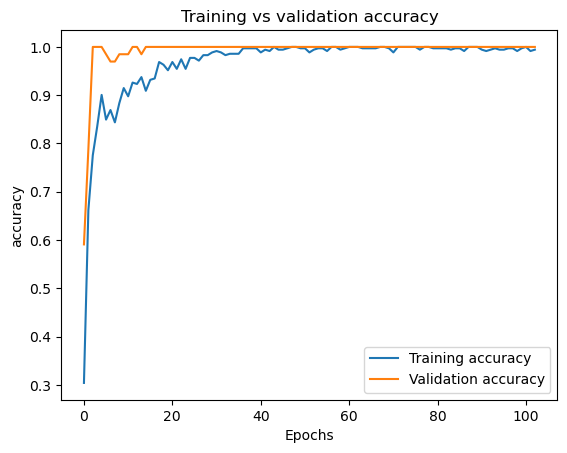

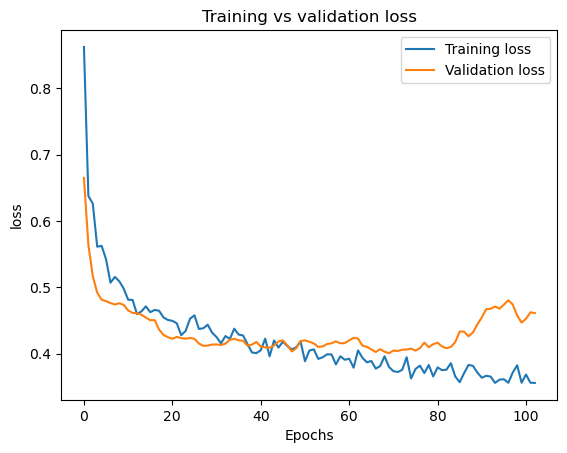

In [75]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title(f'Training vs validation {metric}')
    plt.legend()
    plt.show()

# Plot accuracy
plot_metrics(results, 'accuracy')

# Plot loss
plot_metrics(results, 'loss')

Convert probability results to class predictions

In [76]:
# Convert predicted probabilities back to ordinal classes.
# Uses the first point where predictions drop below 0.5 as the class boundary.

n_samples = predictions.shape[0]
predictions_ordinal = np.zeros(n_samples)

for i in range(n_samples):
    # Find first threshold where probability drops below 0.5
    threshold_crossed = np.argmax(predictions[i] < 0.5)
    if threshold_crossed == 0 and predictions[i, 0] >= 0.5:   # If no threshold is crossed, assign highest class
        predictions_ordinal[i] = predictions.shape[1]
    else:
        predictions_ordinal[i] = threshold_crossed


Calculate accuracy metrics (omitting highest class due to NaN)

In [77]:
print("OVERALL ACCURACY")
print(f"Exact accuracy: {np.mean(y_test_orig == predictions_ordinal)}")
print(f'Accuracy within one: {np.sum(abs(y_test_orig - predictions_ordinal) <= 1) / len(predictions_ordinal)}')
print(f'MAE: {np.mean(abs(y_test_orig - predictions_ordinal))}')
print()
print("ACCURACY BY RATING")
print("Exact accuracy")
running = 0
for class_label in range(classes-1):
    class_mask = (y_test_orig == class_label)
    class_accuracy = np.mean(y_test_orig[class_mask] == predictions_ordinal[class_mask])
    running += class_accuracy
    print(f"Class {class_label} accuracy: {class_accuracy:.3f}")
print(f"Mean accuracy of equally weighted classes: {running/4:.3f}")

print()
print("Accuracy within one")
running = 0
for class_label in range(classes-1):
    class_mask = (y_test_orig == class_label)
    class_accuracy = np.mean(abs(y_test_orig[class_mask] - predictions_ordinal[class_mask]) <= 1)
    running += class_accuracy
    print(f"Class {class_label} accuracy: {class_accuracy:.3f}")
print(f"Mean accuracy-within-one of equally weighted classes: {running/4:.3f}")

print()
print(classification_report(y_test_orig, predictions_ordinal))

OVERALL ACCURACY
Exact accuracy: 0.425
Accuracy within one: 0.925
MAE: 0.65

ACCURACY BY RATING
Exact accuracy
Class 0 accuracy: 0.000
Class 1 accuracy: 0.857
Class 2 accuracy: 0.278
Class 3 accuracy: 0.000
Mean accuracy of equally weighted classes: 0.284

Accuracy within one
Class 0 accuracy: 0.750
Class 1 accuracy: 1.000
Class 2 accuracy: 1.000
Class 3 accuracy: 0.500
Mean accuracy-within-one of equally weighted classes: 0.812

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.40      0.86      0.55        14
           2       0.50      0.28      0.36        18
           3       0.00      0.00      0.00         4

    accuracy                           0.42        40
   macro avg       0.23      0.28      0.23        40
weighted avg       0.37      0.42      0.35        40



Checking correlation of predictions to actual results, using test set 

Correlation between observations and predictions: 0.179
Standard deviation of MAE: 0.614


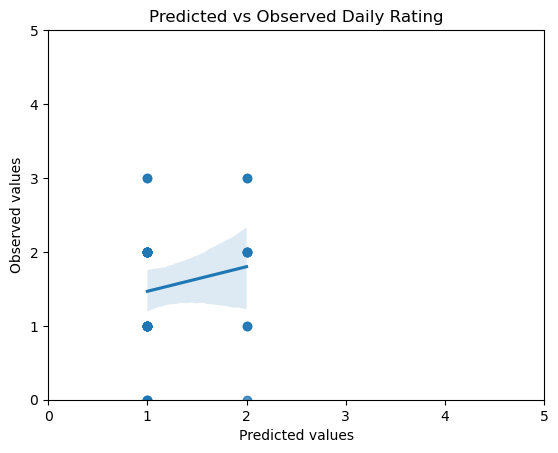

In [78]:
# Correlation and standard deviation of the errors
print(f'Correlation between observations and predictions: {round(np.corrcoef(y_test_orig, predictions_ordinal)[0][1], 3)}') 
print(f'Standard deviation of MAE: {round(np.std(np.absolute(np.subtract(y_test_orig, predictions_ordinal))), 3)}')

# Plotting lowess and linear regression lines, with 95% confidence interval for latter
sns.regplot(y = y_test_orig, x = predictions_ordinal)
plt.title('Predicted vs Observed Daily Rating')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.xlim(0, 5)
plt.ylim(0,5)
plt.show()

**Discussion:** This discussion is based on the test set (n=40), which makes the conclusions conservative. The lowest (i.e. best) MAE on the validation set was 